# Data analysis
2019.03.18 - 2019.04.07

In this file, I'll get to prepping some linguistic analysis.

## Summary of code
- Read in CSV files made after cleaning the BALC corpus (CEPA essays, `cepa.csv` -> `cepa_df`, and lemmas from CEPA essays `filtered_balc_lemmas.csv` -> `cepa_lemmas`)
- Merge the lemmas from the CEPA essays and PELIC Arabic Level 3
    - Filter lemmas, removing any lemma that occurs less than 100 times in either corpus
    - Find mass and count nouns to utilize for analysis
- I ended up re-picking some of the nouns in the update
- Pick a sample of three files for levels 3-6 in BALC to run analyses on based on the new targets and saving that as a csv file in the data folder of my project

### Set-up

In [1]:
import pandas as pd
import numpy as np
import re 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%pprint            # to turn off pretty printing

Pretty printing has been turned OFF


In [2]:
# import cepa_df again
cepa_df = pd.read_csv("../private/cepa.csv", index_col=[0])
# import cepa_lemmas
cepa_lemmas = pd.read_csv("../private/filtered_balc_lemmas.csv", index_col=[0])

# check they've read in correctly
cepa_df.head()
cepa_lemmas.head()

,Filename,Level,Original_Text,Normalized_Essay,Revised_Essay,tokens,token_count,TTR,Guiraud,pos,lemmas
0,200607296,3,\t\t\t\tCEPA 3 200607296\n\n\n\nNow I tell you...,Now I tell you why my worst holiday ever in th...,Now I tell you why my worst holiday ever in th...,"['Now', 'I', 'tell', 'you', 'why', 'my', 'wors...",207,0.492754,7.089490,"[(Now, 'RB'), (I, 'PRP'), (tell, 'VBP'), (you,...","['now', '-PRON-', 'tell', '-PRON-', 'why', '-P..."
1,200607457,4,\t\t\t\tCEPA 4 200607457\n\n\n\n ...,My worst holiday Last year I have just had the...,My worst holiday Last year I have just had the...,"['My', 'worst', 'holiday', 'Last', 'year', 'I'...",180,0.572222,7.677167,"[(My, 'PRP$'), (worst, 'JJS'), (holiday, 'NN')...","['-PRON-', 'bad', 'holiday', 'last', 'year', '..."
2,200600487,5,\t\t\t\tCEPA 5 200600487\n\n\n\n\nEvery body i...,Every body in this life have a favourite posse...,Every body in this life have a favourite posse...,"['Every', 'body', 'in', 'this', 'life', 'have'...",229,0.445415,6.740350,"[(Every, 'DT'), (body, 'NN'), (in, 'IN'), (thi...","['every', 'body', 'in', 'this', 'life', 'have'..."
3,200608016,4,\t\t\t\tCEPA 4 200608016\n\n\n\nEvery body hav...,Every body have a lot ofpossessions in this li...,Every body have a lot ofpossessions in this li...,"['Every', 'body', 'have', 'a', 'lot', 'ofposse...",156,0.608974,7.606087,"[(Every, 'DT'), (body, 'NN'), (have, 'VBP'), (...","['every', 'body', 'have', 'a', 'lot', 'ofposse..."
4,200611825,1,\t\t\t\tCEPA 1 200611825\n\n\n\nyou go in the ...,you go in the oman just had the perfect holida...,you go in the oman just had the perfect holida...,"['you', 'go', 'in', 'the', 'oman', 'just', 'ha...",27,0.629630,3.271652,"[(you, 'PRP'), (go, 'VBP'), (in, 'IN'), (the, ...","['-PRON-', 'go', 'in', 'the', 'oman', 'just', ..."


,lemma,counts
0,the,13677
1,and,10492
2,be,10213
3,to,8692
4,in,6122


#### Review of CEPA essay makeup
Here, information about token count per level and number of texts per level can be found.

In [3]:
# token count by level
cepa_df.groupby('Level')['token_count'].describe()

# Guiraud's R by level
cepa_df.groupby('Level')['Guiraud'].describe()

,count,mean,std,min,25%,50%,75%,max
Level,,,,,,,,
1,276.0,50.409420,35.132618,0.0,24.75,43.0,65.00,199.0
2,292.0,94.287671,44.056346,10.0,59.75,86.5,123.00,310.0
3,250.0,138.056000,47.681305,38.0,105.25,134.0,164.50,316.0
4,297.0,200.373737,50.291163,5.0,167.00,200.0,232.00,343.0
5,299.0,231.862876,51.702926,97.0,193.50,227.0,272.00,397.0
6,250.0,246.748000,53.685426,116.0,210.00,243.0,281.75,392.0


,count,mean,std,min,25%,50%,75%,max
Level,,,,,,,,
1,276.0,4.453267,1.134710,0.000000,3.674235,4.431016,5.144595,8.148217
2,292.0,5.125821,0.868385,2.549510,4.587562,5.098895,5.644995,8.357143
3,250.0,5.765952,0.861545,3.487429,5.100637,5.759068,6.425288,8.606922
4,297.0,6.905933,0.823044,2.236068,6.392330,6.928203,7.483554,9.442491
5,299.0,7.412893,0.706253,5.637345,6.928925,7.341303,7.832240,9.879188
6,250.0,8.076132,0.734736,6.288943,7.543654,8.000616,8.554658,10.266019


In [4]:
# import seaborn and plt
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Total Number of Essays per Level')

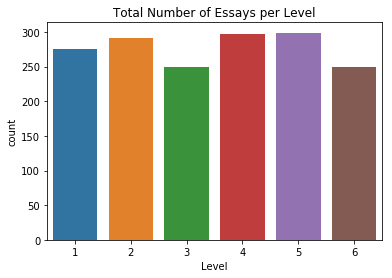

In [5]:
# visualize number of essays
fig1 = sns.countplot(x="Level", data=cepa_df)
fig1.set_title("Total Number of Essays per Level")

Text(0.5, 1.0, 'Token Count by Level')

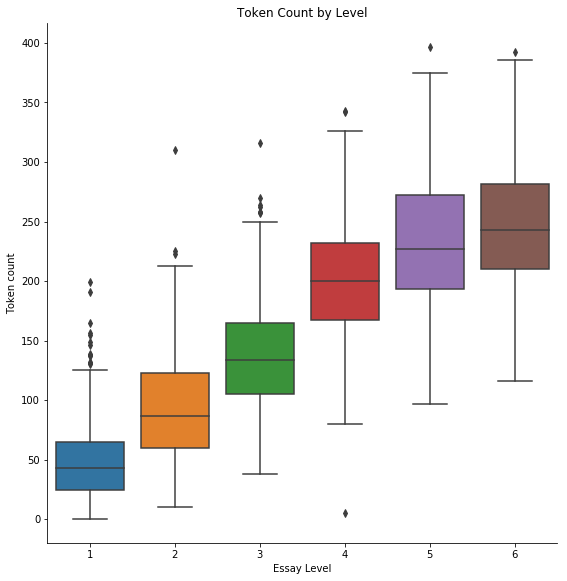

In [6]:
# Token Counts for Essays by Level
fig2 = sns.catplot(x='Level', y='token_count', kind='box', data=cepa_df, height=8)
fig2.set_axis_labels(x_var="Essay Level", y_var="Token count")
plt.title('Token Count by Level')

Text(0.5, 1.0, "Guiraud's R by Level")

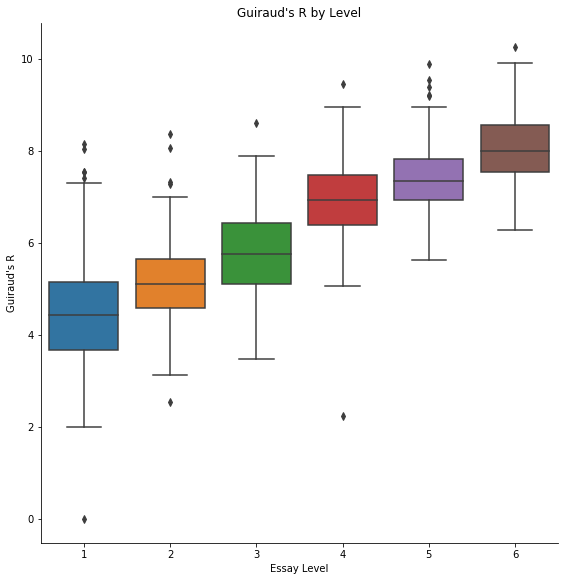

In [7]:
# Token Counts for Essays by Level
fig3 = sns.catplot(x='Level', y='Guiraud', kind='box', data=cepa_df, height=8)
fig3.set_axis_labels(x_var="Essay Level", y_var="Guiraud's R")
plt.title('Guiraud\'s R by Level')

#### Let's fine-tune a little
In this section, I'll start filtering some of the data out (concerning CEPA).
- I fine-tune based on some informatio from browsing through the PELIC dataset
    - Choosing files that are level 3 or higher 
    - Token count must be between 10 tokens and 400

In [8]:
# make and apply filters
filters = (cepa_df.Level >= 3) & (cepa_df.token_count >= 10) & (cepa_df.token_count <= 400)
cepa_target = cepa_df[filters]

cepa_target.head()

,Filename,Level,Original_Text,Normalized_Essay,Revised_Essay,tokens,token_count,TTR,Guiraud,pos,lemmas
0,200607296,3,\t\t\t\tCEPA 3 200607296\n\n\n\nNow I tell you...,Now I tell you why my worst holiday ever in th...,Now I tell you why my worst holiday ever in th...,"['Now', 'I', 'tell', 'you', 'why', 'my', 'wors...",207,0.492754,7.089490,"[(Now, 'RB'), (I, 'PRP'), (tell, 'VBP'), (you,...","['now', '-PRON-', 'tell', '-PRON-', 'why', '-P..."
1,200607457,4,\t\t\t\tCEPA 4 200607457\n\n\n\n ...,My worst holiday Last year I have just had the...,My worst holiday Last year I have just had the...,"['My', 'worst', 'holiday', 'Last', 'year', 'I'...",180,0.572222,7.677167,"[(My, 'PRP$'), (worst, 'JJS'), (holiday, 'NN')...","['-PRON-', 'bad', 'holiday', 'last', 'year', '..."
2,200600487,5,\t\t\t\tCEPA 5 200600487\n\n\n\n\nEvery body i...,Every body in this life have a favourite posse...,Every body in this life have a favourite posse...,"['Every', 'body', 'in', 'this', 'life', 'have'...",229,0.445415,6.740350,"[(Every, 'DT'), (body, 'NN'), (in, 'IN'), (thi...","['every', 'body', 'in', 'this', 'life', 'have'..."
3,200608016,4,\t\t\t\tCEPA 4 200608016\n\n\n\nEvery body hav...,Every body have a lot ofpossessions in this li...,Every body have a lot ofpossessions in this li...,"['Every', 'body', 'have', 'a', 'lot', 'ofposse...",156,0.608974,7.606087,"[(Every, 'DT'), (body, 'NN'), (have, 'VBP'), (...","['every', 'body', 'have', 'a', 'lot', 'ofposse..."
6,200608959,5,\t\t\t\tCEPA 5 200608959\n\n\n\nI have just ha...,I have just had the perfect and the best holid...,I have just had the perfect and the best holid...,"['I', 'have', 'just', 'had', 'the', 'perfect',...",277,0.440433,7.330270,"[(I, 'PRP'), (have, 'VBP'), (just, 'RB'), (had...","['-PRON-', 'have', 'just', 'have', 'the', 'per..."


In [9]:
# let's see how many essays we have left and some stats
cepa_target.groupby('Level')['token_count'].describe()

,count,mean,std,min,25%,50%,75%,max
Level,,,,,,,,
3,250.0,138.056000,47.681305,38.0,105.25,134.0,164.50,316.0
4,296.0,201.033784,49.070812,80.0,167.00,200.5,232.00,343.0
5,299.0,231.862876,51.702926,97.0,193.50,227.0,272.00,397.0
6,250.0,246.748000,53.685426,116.0,210.00,243.0,281.75,392.0


We only lost 1 essay from Level 4, so that's not too bad. 

### Lemma lists and noun choice
Now we'll compare lemmas across the two corpora, with respect to Arabic L1 speakers. I'll check the targets against the Korean and Spanish speakers as well. Alan Juffs did lemma counts on PELIC already, so we'll be using this. Thanks, Alan!

In [10]:
pelic_lemmas = pd.read_csv('/Users/elenacimino/Alan-Workspace/FREQ_Lists/Arabic_Level_3_FREQ2000_AAAL.csv', 
                           index_col=[0])
pelic_lemmas.head()

,lemma,count
1,the,46073.0
2,be,41895.0
3,i,34769.0
4,to,34572.0
5,and,25170.0


In [11]:
# we'll merge the two dfs so we can get the mutual lemmas
lemmas = pd.merge(cepa_lemmas, pelic_lemmas, on=['lemma'])

lemmas.head()

,lemma,counts,count
0,the,13677,46073.0
1,and,10492,25170.0
2,be,10213,41895.0
3,to,8692,34572.0
4,in,6122,23965.0


In [12]:
# I want to throw lemmas out if they occur less than 50 times in BALC or less than 100 times in PELIC
# The below code doesn't work because 'count' is a method. so I need to re-index the columns

# lemmas[lemmas.counts >= 50 & lemmas.count >= 100]

In [13]:
lemmas.columns=['lemma', 'counts_cepa', 'counts_pelic']
lemmas.head()

,lemma,counts_cepa,counts_pelic
0,the,13677,46073.0
1,and,10492,25170.0
2,be,10213,41895.0
3,to,8692,34572.0
4,in,6122,23965.0


In [14]:
poss_targets = lemmas[(lemmas.counts_cepa >= 50) & (lemmas.counts_pelic >= 100)]
poss_targets

,lemma,counts_cepa,counts_pelic
0,the,13677,46073.0
1,and,10492,25170.0
2,be,10213,41895.0
3,to,8692,34572.0
4,in,6122,23965.0
5,go,4995,4774.0
6,a,3913,21613.0
7,have,2823,14836.0
8,that,2504,8401.0
9,of,2411,17055.0


In [15]:
targets = list(poss_targets.lemma)
targets

['the', 'and', 'be', 'to', 'in', 'go', 'a', 'have', 'that', 'of', 'with', 'very', 'holiday', 'so', 'for', 'see', 'there', 'not', 'because', 'family', 'do', 'like', 'this', 'can', 'day', 'good', 'but', 'time', 'when', 'all', 'after', 'bad', 'father', 'many', 'on', 'friend', 'one', 'place', 'thing', 'at', 'play', 'people', 'take', 'about', 'will', 'some', 'last', 'happy', 'from', 'ever', 'spend', 'sister', 'nice', 'get', 'come', 'summer', 'wonderful', 'mother', 'also', 'brother', 'enjoy', 'car', 'love', 'film', 'back', 'then', 'visit', 'al', 'what', 'as', 'life', 'want', 'make', 'park', 'by', 'much', 'hotel', 'movie', 'first', 'just', 'really', 'home', 'travel', 'eat', 'country', 'big', 'tell', 'most', 'beautiful', 'which', 'think', 'weekend', 'who', 'stay', 'know', 'every', 'where', 'year', 'city', 'week', 'start', 'sea', 'feel', 'two', 'next', 'or', 'other', 'buy', 'lot', 'shopping', 'call', 'could', 'out', 'more', 'mall', 'food', 'say', 'help', 'i', 'no', 'house', 'watch', 'weather', 

I'm going to remove the stop words from the list of lemmas because a lot of the lemmas are (naturally) pronouns and prepositions. NLTK has a convenient set of stop words for English, which I'll use, that I'll use to remove stop words from targets.

In [16]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

for targ in targets:
    if targ in stop_words:
        targets.remove(targ)    
    elif targ.isalpha() == False:
        targets.remove(targ)    
    elif len(targ) < 2:
        targets.remove(targ)    
        
len(targets)

270

So there are 270 possible targets now... Let's see if we can find any abstract and concrete nouns in there (we definitely will be able to).

In [17]:
targets

['and', 'to', 'go', 'have', 'of', 'very', 'holiday', 'for', 'see', 'not', 'family', 'like', 'can', 'day', 'good', 'time', 'all', 'bad', 'father', 'many', 'friend', 'one', 'place', 'thing', 'play', 'people', 'take', 'will', 'last', 'happy', 'ever', 'spend', 'sister', 'nice', 'get', 'come', 'summer', 'wonderful', 'mother', 'also', 'brother', 'enjoy', 'car', 'love', 'film', 'back', 'visit', 'al', 'as', 'life', 'want', 'make', 'park', 'much', 'hotel', 'movie', 'first', 'really', 'home', 'travel', 'eat', 'country', 'big', 'tell', 'beautiful', 'think', 'weekend', 'stay', 'know', 'every', 'year', 'city', 'week', 'start', 'sea', 'feel', 'two', 'next', 'other', 'buy', 'lot', 'shopping', 'call', 'could', 'more', 'mall', 'food', 'say', 'help', 'no', 'house', 'watch', 'weather', 'would', 'live', 'look', 'school', 'fun', 'decide', 'any', 'shop', 'use', 'up', 'give', 'finally', 'great', 'arrive', 'room', 'find', 'sleep', 'animal', 'world', 'hour', 'way', 'football', 'old', 'story', 'work', 'happen',

I try to separate the list of nouns as either count, mass, or flexible nouns. This isn't a perfect split, as it's based on my native speaker intutions as a NS of American English. I try to account for differences between American English and British English. For example, "holiday" seems to be only count in American English but non-count in British English.

In [18]:
count = ['father', 'friend', 'mother', 'sister', 'mother', 'park', 'hotel', 'movie', 'woman', 
         'exam', 'place', 'thing', 'brother', 'park', 'hotel', 'movie', 'country', 'weekend', 
         'year', 'city', 'week', 'mall', 'house', 'shop', 'room', 'world', 'animal', 'hour', 
         'way', 'football', 'story', 'trip', 'beach', 'game', 'airport', 'topic', 'uncle', 
        'book', 'child', 'computer', 'girl', 'hospital', 'plane', 'book', 'hospital', 'plane', 
        'problem', 'vacation', 'parent', 'name', 'gift', 'wish', 'person', 'body', 'tree', 'show', 
        'picture', 'idea', 'reason', 'street', 'change', 'desert', 'face', 'boy', 'activity', 'doctor', 'exam', 
         'dream', 'area', 'head', 'bed', 'woman', 'phone', 'drink', 'view']

mass = ['time', 'land', 'shopping', 'food', 'weather', 'sleep', 'work', 'hope', 'water', 'rest', 'rain', 'egypt',
       'english', 'money', 'sea']

flexible = ['holiday', 'family', 'day', 'people', 'summer', 'car', 'love', 'film', 'life', 
            'home', 'country', 'help', 'school', 'man', 'night', 'plan', 'lunch', 'dinner', 
           'night', 'morning', 'month', 'fish', 'sport']

In [19]:
# making some filters
ct_filter = (lemmas.lemma.isin(count))
ms_filter = (lemmas.lemma.isin(mass))
fl_filter = (lemmas.lemma.isin(flexible))

In [20]:
# creating individualized df's for count, mass, and ambiguous nouns
count_nouns = lemmas[ct_filter]
mass_nouns = lemmas[ms_filter]
either_nouns = lemmas[fl_filter]

Let's take a closer look, shall we?

In [21]:
count_nouns

,lemma,counts_cepa,counts_pelic
32,father,861,894.0
35,friend,844,2441.0
37,place,770,1883.0
38,thing,741,2637.0
51,sister,572,412.0
57,mother,526,425.0
59,brother,486,621.0
73,park,431,247.0
76,hotel,421,292.0
77,movie,412,938.0


In [22]:
mass_nouns

,lemma,counts_cepa,counts_pelic
27,time,984,3595.0
103,sea,301,285.0
111,shopping,282,222.0
117,food,267,3829.0
124,weather,253,685.0
147,sleep,188,361.0
155,work,179,2194.0
172,hope,155,317.0
189,water,125,583.0
262,rest,84,127.0


In [23]:
either_nouns

,lemma,counts_cepa,counts_pelic
12,holiday,2067,159.0
19,family,1261,2054.0
24,day,1028,2257.0
41,people,724,4280.0
55,summer,553,304.0
61,car,485,1845.0
62,love,483,951.0
63,film,471,108.0
70,life,444,1984.0
81,home,398,1693.0


In [24]:
# Final filter -- has to be count or mass noun, and counts for lemmas in cepa must be at least 50.
filters = ((lemmas.lemma.isin(count)) | (lemmas.lemma.isin(mass))) & \
(lemmas.counts_cepa >= 50)

In [25]:
# to apply to a dataframe after doing a final filter
def nounType(word):
    if word in list(count_nouns.lemma):
        return 'count'
    elif word in list(mass_nouns.lemma):
        return 'mass'
    else: return 'ambi'

# possible targets
lemmas = lemmas[filters]
lemmas['type'] = lemmas.lemma.apply(nounType)
lemmas

,lemma,counts_cepa,counts_pelic,type
27,time,984,3595.0,mass
32,father,861,894.0,count
35,friend,844,2441.0,count
37,place,770,1883.0,count
38,thing,741,2637.0,count
51,sister,572,412.0,count
57,mother,526,425.0,count
59,brother,486,621.0,count
73,park,431,247.0,count
76,hotel,421,292.0,count


Choosing targets:

In [26]:
original_targets = ['egypt', 'sea', 'shopping', 'weather', 'water', 'rain', # mass nouns
                  'football', 'beach', 'hospital', 'mall', 'weekend', 'book']

In [27]:
filters = (lemmas.lemma.isin(original_targets))
original_targets_df = lemmas[filters]
original_targets_df

,lemma,counts_cepa,counts_pelic,type
91,weekend,347,399.0,count
103,sea,301,285.0,mass
111,shopping,282,222.0,mass
116,mall,268,159.0,count
124,weather,253,685.0,mass
152,football,185,152.0,count
163,beach,165,387.0,count
189,water,125,583.0,mass
194,book,121,685.0,count
208,hospital,115,209.0,count


In [28]:
original_targets_df.describe()

,counts_cepa,counts_pelic
count,12.000000,12.000000
mean,192.333333,340.750000
std,94.418154,206.647317
min,72.000000,139.000000
25%,119.500000,177.750000
50%,175.000000,253.500000
75%,271.500000,445.000000
max,347.000000,685.000000


In [29]:
# write this out to a csv file in case it's needed later
original_targets_df.to_csv('chosen_targets.csv')

### Nouns in the CEPA essays
Let's check and make sure we have some kind of distribution across different for these nouns.

In [30]:
cepa_df[cepa_df.lemmas.str.contains('sea') == True].groupby('Level')['token_count'].describe()
cepa_df[cepa_df.lemmas.str.contains('egypt') == True].groupby('Level')['token_count'].describe()

,count,mean,std,min,25%,50%,75%,max
Level,,,,,,,,
1,16.0,93.125000,44.612218,23.0,65.50,83.0,119.25,199.0
2,43.0,103.976744,45.484423,45.0,66.50,102.0,126.50,223.0
3,53.0,137.226415,43.667292,57.0,108.00,135.0,160.00,264.0
4,56.0,210.178571,44.469850,114.0,188.75,211.5,239.00,312.0
5,46.0,242.717391,42.842172,172.0,212.75,238.0,276.50,345.0
6,43.0,253.790698,49.124506,164.0,219.50,251.0,293.00,348.0


,count,mean,std,min,25%,50%,75%,max
Level,,,,,,,,
1,1.0,102.000000,NaN,102.0,102.00,102.0,102.0,102.0
3,4.0,118.250000,33.599355,82.0,94.75,118.0,141.5,155.0
4,7.0,192.428571,31.111933,130.0,188.00,197.0,207.5,229.0
5,8.0,261.000000,41.768067,195.0,232.75,275.5,290.5,307.0
6,7.0,232.857143,39.010377,176.0,204.00,247.0,261.0,277.0


In [31]:
for targ in original_targets:
    print(targ+":")
    print(cepa_df[cepa_df.lemmas.str.contains(targ) == True].groupby('Level')['token_count'].describe())
    print()

egypt:
       count        mean        std    min     25%    50%    75%    max
Level                                                                  
1        1.0  102.000000        NaN  102.0  102.00  102.0  102.0  102.0
3        4.0  118.250000  33.599355   82.0   94.75  118.0  141.5  155.0
4        7.0  192.428571  31.111933  130.0  188.00  197.0  207.5  229.0
5        8.0  261.000000  41.768067  195.0  232.75  275.5  290.5  307.0
6        7.0  232.857143  39.010377  176.0  204.00  247.0  261.0  277.0

sea:
       count        mean        std    min     25%    50%     75%    max
Level                                                                   
1       16.0   93.125000  44.612218   23.0   65.50   83.0  119.25  199.0
2       43.0  103.976744  45.484423   45.0   66.50  102.0  126.50  223.0
3       53.0  137.226415  43.667292   57.0  108.00  135.0  160.00  264.0
4       56.0  210.178571  44.469850  114.0  188.75  211.5  239.00  312.0
5       46.0  242.717391  42.842172  172.0  2

In [32]:
spanish_lemmas = pd.read_csv('/Users/elenacimino/Alan-Workspace/FREQ_Lists/SPAN_Level3_FREQ2000_Lema.csv', 
                           index_col=[0])
korean_lemmas = pd.read_csv('/Users/elenacimino/Alan-Workspace/FREQ_Lists/Korean_Level_3_FREQ3000_AAAL.csv',
                           index_col=[0])

spanish_lemmas.head()
korean_lemmas.head()

,lemma,count,per mil,totall words
NaN,NaN,NaN,50.372758,19852.0
1.0,i,54352.0,NaN,NaN
2.0,the,53043.0,NaN,NaN
3.0,be,51531.0,NaN,NaN
4.0,to,31332.0,NaN,NaN


,lemma,count
1,be,44083
2,i,35716
3,the,33163
4,to,30623
5,a,29139


In [33]:
# checking the targets are in the other lemma lists...
for targ in original_targets:
    if targ not in list(spanish_lemmas.lemma):
        print(targ)

# could be a problem

shopping
rain


In [34]:
any(spanish_lemmas.lemma.str.contains('shop') == True)
any(spanish_lemmas.lemma.str.contains('rain') == True)
spanish_lemmas[(spanish_lemmas.lemma.str.contains('shop') | spanish_lemmas.lemma.str.contains('rain'))]

True

True

,lemma,count,per mil,totall words
432.0,train,252.0,NaN,NaN
436.0,shop,252.0,NaN,NaN
557.0,workshop,201.0,NaN,NaN
896.0,brainstorm,101.0,NaN,NaN
1056.0,bookshop,101.0,NaN,NaN
1760.0,brain,50.0,NaN,NaN


In [35]:
# checking the targets are in the other lemma lists...
for targ in original_targets:
    if targ not in list(korean_lemmas.lemma):
        print(targ)
        
# Looks like Korean is okay.

See if we can't get a data sample....

In [36]:
samples = cepa_df.sample(10)
samples
samples.to_csv("../data/cepa_samples.csv")

,Filename,Level,Original_Text,Normalized_Essay,Revised_Essay,tokens,token_count,TTR,Guiraud,pos,lemmas
912,200610836,2,\t\t\t\tCEPA 2 200610836\n\n\n\nImagine you ha...,Imagine you have just had the worst holiday ev...,Imagine you have just had the worst holiday ev...,"['Imagine', 'you', 'have', 'just', 'had', 'the...",112,0.517857,5.480485,"[(Imagine, 'VB'), (you, 'PRP'), (have, 'VBP'),...","['imagine', '-PRON-', 'have', 'just', 'have', ..."
970,200605193,1,\t\t\t\tCEPA ! 200605193\n\n\n\nImagine you ha...,Imagine you have just had the worst holiday ev...,Imagine you have just had the worst holiday ev...,"['Imagine', 'you', 'have', 'just', 'had', 'the...",59,0.627119,4.816990,"[(Imagine, 'VB'), (you, 'PRP'), (have, 'VBP'),...","['imagine', '-PRON-', 'have', 'just', 'have', ..."
880,200607194,5,\t\t\t\tCEPA 5 200607194\n\n\n\nIn last summer...,"In last summer, I spend my holiday with my fri...","In last summer, I spend my holiday with my fri...","['In', 'last', 'summer', ',', 'I', 'spend', 'm...",229,0.467249,7.070759,"[(In, 'IN'), (last, 'JJ'), (summer, 'NN'), (,,...","['in', 'last', 'summer', ',', '-PRON-', 'spend..."
306,200600866,5,\t\t\t\tCEPA 5 200600866\n\n\n\nI spent a wond...,I spent a wonderful holiday in Eygpt . I am an...,I spent a wonderful holiday in Eygpt . I am an...,"['I', 'spent', 'a', 'wonderful', 'holiday', 'i...",217,0.437788,6.449020,"[(I, 'PRP'), (spent, 'VBD'), (a, 'DT'), (wonde...","['-PRON-', 'spend', 'a', 'wonderful', 'holiday..."
626,200605779,4,\t\t\t\tCEPA 4 200605779\n\n\n\n ...,Summer holiday Last summer holiday was my best...,Summer holiday Last summer holiday was my best...,"['Summer', 'holiday', 'Last', 'summer', 'holid...",158,0.531646,6.682681,"[(Summer, 'NN'), (holiday, 'NN'), (Last, 'JJ')...","['summer', 'holiday', 'last', 'summer', 'holid..."
1376,200611777,3,\t\t\t\tCEPA 3 200611777\n\n\n\nThere are many...,There are many things make a good holiday. In ...,There are many things make a good holiday. In ...,"['There', 'are', 'many', 'things', 'make', 'a'...",113,0.539823,5.738397,"[(There, 'EX'), (are, 'VBP'), (many, 'JJ'), (t...","['there', 'be', 'many', 'thing', 'make', 'a', ..."
1554,200602896,1,\t\t\t\tCEPA 1 200602896\n\n\n\nThe bad holid...,The bad holiday in my lify. Befor travel in Th...,The bad holiday in my lify. Befor travel in Th...,"['The', 'bad', 'holiday', 'in', 'my', 'lify', ...",20,0.750000,3.354102,"[(The, 'DT'), (bad, 'JJ'), (holiday, 'NN'), (i...","['the', 'bad', 'holiday', 'in', '-PRON-', 'lif..."
660,200607224,3,\t\t\t\tCEPA 3 200607224\n\n\n\nIn first I wan...,In first I want taking about the worst holiday...,In first I want taking about the worst holiday...,"['In', 'first', 'I', 'want', 'taking', 'about'...",100,0.560000,5.600000,"[(In, 'IN'), (first, 'JJ'), (I, 'PRP'), (want,...","['in', 'first', '-PRON-', 'want', 'take', 'abo..."
1159,200605588,4,\t\t\t\tCEPA 4 200605588\n\n\n\nAfter hard wee...,After hard week that er spend it all time by s...,After hard week that er spend it all time by s...,"['After', 'hard', 'week', 'that', 'er', 'spend...",242,0.557851,8.678129,"[(After, 'IN'), (hard, 'JJ'), (week, 'NN'), (t...","['after', 'hard', 'week', 'that', 'er', 'spend..."
280,200612529,3,\t\t\t\tCEPA 3 200612529\n\n\n\nI’m just my ho...,I'm just my holid^a^y in the sea it was vary e...,I'm just my holiday in the sea it was vary enj...,"['I', ""'m"", 'just', 'my', 'holiday', 'in', 'th...",124,0.524194,5.837172,"[(I, 'PRP'), ('m, 'VBP'), (just, 'RB'), (my, '...","['-PRON-', 'be', 'just', '-PRON-', 'holiday', ..."


## Summary 

So, I compared the lemmas between the CEPA essays and (Level 3 lemmas) for Arabic, as well as Spanish and Korean. I trimmed down my list from the projected 10 each to 6 each for two reasons: for one, it is somewhat difficult to find enough mass and count nouns in each corpus and account for differences in usage between American and British English, as well as the difference in size between the corpora; for another, I'm trying to do quite a bit with this project. I'll be comparing Arabic L1 speakers across two different corpora, as well as comparing three different L1s: Korean, Spanish, and Arabic. Given all this, I decided to shorten the amount of nouns to look at, since I will probably need to limit the amount of people I look at for each L1.

I have a tentative list of target nouns to compare for analysis and confirmed, at the least, that I can compare these nouns between the Arabic L1 English learners in BALC and PELIC. I believe I should be able to compare 3-5 speakers each, given that I also want to compare across languages and don't want to overload myself.

The Spanish Level 3 PELIC lemma list doesn't contain 'shopping', but does contain 'shop', so I will look into this further to see if there are nominal forms of 'shop(ping)' to see if I can use this. I may have to throw out 'rain' as a target.

## Updates: 
2019.04.07 - ?

Because there isn't very much data in Spanish 2, Alan suggested working with levels 3+. However, some of the words I originally picked were somewhat problematic, so I decided to work with a smaller list, below:

In [37]:
lemmas[(lemmas.type == 'mass')]

,lemma,counts_cepa,counts_pelic,type
27,time,984,3595.0,mass
103,sea,301,285.0,mass
111,shopping,282,222.0,mass
117,food,267,3829.0,mass
124,weather,253,685.0,mass
147,sleep,188,361.0,mass
155,work,179,2194.0,mass
172,hope,155,317.0,mass
189,water,125,583.0,mass
262,rest,84,127.0,mass


In [38]:
lemmas[(lemmas.type == 'count')]

,lemma,counts_cepa,counts_pelic,type
32,father,861,894.0,count
35,friend,844,2441.0,count
37,place,770,1883.0,count
38,thing,741,2637.0,count
51,sister,572,412.0,count
57,mother,526,425.0,count
59,brother,486,621.0,count
73,park,431,247.0,count
76,hotel,421,292.0,count
77,movie,412,938.0,count


In [39]:
new_targets = ['sea', 'time', 'food', 'water', 'money',
              'place', 'week', 'book', 'story', 'park']
filters = (lemmas.lemma.isin(new_targets))
new_targets_df = lemmas[filters]
new_targets_df.to_csv('chosen_targets_new.csv')

In [40]:
for targ in new_targets:
    if targ not in list(spanish_lemmas.lemma):
        print(targ)

In [41]:
for targ in new_targets:
    if targ not in list(korean_lemmas.lemma):
        print(targ)

So these are all in the Spanish, Korean, and Arabic essays. Great! Now I'll need to grab samples to actually do analysis on.

### Picking samples of data
I'll use `.sample()` to get the samples, and `random_state` allows for replicability in methodology.

I tried to make a UDF to do this for me, but it wasn't working. For now, I just did this by hand.

###### CEPA samples

In [42]:
# essay d ended up pulling an essay with bookINGS (for a holiday) instead of about 'book'/'books'
a = cepa_df[(cepa_df.Level == 3) & (cepa_df.lemmas.str.contains('book', na=False))].sample(random_state=1)
b = cepa_df[(cepa_df.Level == 4) & (cepa_df.lemmas.str.contains('book', na=False))].sample(random_state=1)
c = cepa_df[(cepa_df.Level == 5) & (cepa_df.lemmas.str.contains('book', na=False))].sample(random_state=1)
d = cepa_df[(cepa_df.Level == 6) & (cepa_df.lemmas.str.contains('book', na=False))].sample(random_state=5)
balc_book = pd.concat([a, b, c, d], axis=0)
balc_book['targ'] = 'book'

In [43]:
a = cepa_df[(cepa_df.Level == 3) & (cepa_df.lemmas.str.contains('food', na=False))].sample(random_state=1)
b = cepa_df[(cepa_df.Level == 4) & (cepa_df.lemmas.str.contains('food', na=False))].sample(random_state=1)
c = cepa_df[(cepa_df.Level == 5) & (cepa_df.lemmas.str.contains('food', na=False))].sample(random_state=1)
d = cepa_df[(cepa_df.Level == 6) & (cepa_df.lemmas.str.contains('food', na=False))].sample(random_state=1)
balc_food = pd.concat([a, b, c, d], axis=0)
balc_food['targ'] = 'food'

In [44]:
a = cepa_df[(cepa_df.Level == 3) & (cepa_df.lemmas.str.contains('place', na=False))].sample(random_state=1)
b = cepa_df[(cepa_df.Level == 4) & (cepa_df.lemmas.str.contains('place', na=False))].sample(random_state=1)
c = cepa_df[(cepa_df.Level == 5) & (cepa_df.lemmas.str.contains('place', na=False))].sample(random_state=1)
d = cepa_df[(cepa_df.Level == 6) & (cepa_df.lemmas.str.contains('place', na=False))].sample(random_state=1)
balc_place = pd.concat([a, b, c, d], axis=0)
balc_place['targ'] = 'place'

In [45]:
a = cepa_df[(cepa_df.Level == 3) & (cepa_df.lemmas.str.contains('park', na=False))].sample(random_state=1)
b = cepa_df[(cepa_df.Level == 4) & (cepa_df.lemmas.str.contains('park', na=False))].sample(random_state=1)
c = cepa_df[(cepa_df.Level == 5) & (cepa_df.lemmas.str.contains('park', na=False))].sample(random_state=1)
d = cepa_df[(cepa_df.Level == 6) & (cepa_df.lemmas.str.contains('park', na=False))].sample(random_state=1)
balc_park = pd.concat([a, b, c, d], axis=0)
balc_park['targ'] = 'park'

In [46]:
a = cepa_df[(cepa_df.Level == 3) & (cepa_df.lemmas.str.contains('sea', na=False))].sample(random_state=1)
b = cepa_df[(cepa_df.Level == 4) & (cepa_df.lemmas.str.contains('sea', na=False))].sample(random_state=1)
c = cepa_df[(cepa_df.Level == 5) & (cepa_df.lemmas.str.contains('sea', na=False))].sample(random_state=1)
d = cepa_df[(cepa_df.Level == 6) & (cepa_df.lemmas.str.contains('sea', na=False))].sample(random_state=1)
balc_sea = pd.concat([a, b, c, d], axis=0)
balc_sea['targ'] = 'sea'

In [47]:
a = cepa_df[(cepa_df.Level == 3) & (cepa_df.lemmas.str.contains('story', na=False))].sample(random_state=1)
b = cepa_df[(cepa_df.Level == 4) & (cepa_df.lemmas.str.contains('story', na=False))].sample(random_state=1)
c = cepa_df[(cepa_df.Level == 5) & (cepa_df.lemmas.str.contains('story', na=False))].sample(random_state=1)
d = cepa_df[(cepa_df.Level == 6) & (cepa_df.lemmas.str.contains('story', na=False))].sample(random_state=1)
balc_story = pd.concat([a, b, c, d], axis=0)
balc_story['targ'] = 'story'

In [48]:
a = cepa_df[(cepa_df.Level == 3) & (cepa_df.lemmas.str.contains('time', na=False))].sample(random_state=1)
b = cepa_df[(cepa_df.Level == 4) & (cepa_df.lemmas.str.contains('time', na=False))].sample(random_state=1)
c = cepa_df[(cepa_df.Level == 5) & (cepa_df.lemmas.str.contains('time', na=False))].sample(random_state=1)
d = cepa_df[(cepa_df.Level == 6) & (cepa_df.lemmas.str.contains('time', na=False))].sample(random_state=1)
balc_time = pd.concat([a, b, c, d], axis=0)
balc_time['targ'] = 'time'

In [49]:
a = cepa_df[(cepa_df.Level == 3) & (cepa_df.lemmas.str.contains('water', na=False))].sample(random_state=1)
b = cepa_df[(cepa_df.Level == 4) & (cepa_df.lemmas.str.contains('water', na=False))].sample(random_state=1)
c = cepa_df[(cepa_df.Level == 5) & (cepa_df.lemmas.str.contains('water', na=False))].sample(random_state=1)
d = cepa_df[(cepa_df.Level == 6) & (cepa_df.lemmas.str.contains('water', na=False))].sample(random_state=1)
balc_water = pd.concat([a, b, c, d], axis=0)
balc_water['targ'] = 'water'

In [50]:
a = cepa_df[(cepa_df.Level == 3) & (cepa_df.lemmas.str.contains('money', na=False))].sample(random_state=1)
b = cepa_df[(cepa_df.Level == 4) & (cepa_df.lemmas.str.contains('money', na=False))].sample(random_state=1)
c = cepa_df[(cepa_df.Level == 5) & (cepa_df.lemmas.str.contains('money', na=False))].sample(random_state=1)
d = cepa_df[(cepa_df.Level == 6) & (cepa_df.lemmas.str.contains('money', na=False))].sample(random_state=1)
balc_money = pd.concat([a, b, c, d], axis=0)
balc_money['targ'] = 'money'

In [51]:
a = cepa_df[(cepa_df.Level == 3) & (cepa_df.lemmas.str.contains('week', na=False))].sample(random_state=1)
b = cepa_df[(cepa_df.Level == 4) & (cepa_df.lemmas.str.contains('week', na=False))].sample(random_state=1)
c = cepa_df[(cepa_df.Level == 5) & (cepa_df.lemmas.str.contains('week', na=False))].sample(random_state=1)
d = cepa_df[(cepa_df.Level == 6) & (cepa_df.lemmas.str.contains('week', na=False))].sample(random_state=1)
balc_week = pd.concat([a, b, c, d], axis=0)
balc_week['targ'] = 'week'

###### Concatenating all CEPA samples and then writing them out

In [52]:
dfs = [balc_book, balc_money, balc_food, balc_place, balc_sea, balc_story, balc_time, balc_water, balc_week, balc_park]
balc_targets = pd.concat(dfs)

In [53]:
balc_targets.head()

,Filename,Level,Original_Text,Normalized_Essay,Revised_Essay,tokens,token_count,TTR,Guiraud,pos,lemmas,targ
1347,200611403,3,\t\t\t\tCEPA 3 200611403\n\n\n\nLast summer ho...,Last summer holiday iam going with my family t...,Last summer holiday iam going with my family t...,"['Last', 'summer', 'holiday', 'iam', 'going', ...",82,0.536585,4.858987,"[(Last, 'JJ'), (summer, 'NN'), (holiday, 'NN')...","['last', 'summer', 'holiday', 'iam', 'go', 'wi...",book
1171,200608092,4,\t\t\t\tCEPA 4 200608092\n\n\n\nI have just ha...,I have just had the perfect holidy. In my holi...,I have just had the perfect holidy. In my holi...,"['I', 'have', 'just', 'had', 'the', 'perfect',...",188,0.446809,6.126330,"[(I, 'PRP'), (have, 'VBP'), (just, 'RB'), (had...","['-PRON-', 'have', 'just', 'have', 'the', 'per...",book
1441,200603618,5,\t\t\t\tCEPA 5 200603618\n\n\n\nIn the summer ...,In the summer holiday my family dicides to spe...,In the summer holiday my family dicides to spe...,"['In', 'the', 'summer', 'holiday', 'my', 'fami...",215,0.460465,6.751744,"[(In, 'IN'), (the, 'DT'), (summer, 'NN'), (hol...","['in', 'the', 'summer', 'holiday', '-PRON-', '...",book
1530,200607320,6,\t\t\t\tCEPA 6 200607320\n\n\n\nThere have bee...,"There have been many films reteased lately, So...","There have been many films reteased lately, So...","['There', 'have', 'been', 'many', 'films', 're...",234,0.598291,9.152086,"[(There, 'EX'), (have, 'VBP'), (been, 'VBN'), ...","['there', 'have', 'be', 'many', 'film', 'retea...",book
881,200607798,3,\t\t\t\tCEPA 3 200607798\n\nWhere I going to t...,"Where I going to the India with my family , my...","Where I going to the India with my family , my...","['Where', 'I', 'going', 'to', 'the', 'India', ...",151,0.602649,7.405475,"[(Where, 'WRB'), (I, 'PRP'), (going, 'VBG'), (...","['where', '-PRON-', 'go', 'to', 'the', 'india'...",money


In [54]:
balc_targets = balc_targets.reset_index()
balc_targets

,index,Filename,Level,Original_Text,Normalized_Essay,Revised_Essay,tokens,token_count,TTR,Guiraud,pos,lemmas,targ
0,1347,200611403,3,\t\t\t\tCEPA 3 200611403\n\n\n\nLast summer ho...,Last summer holiday iam going with my family t...,Last summer holiday iam going with my family t...,"['Last', 'summer', 'holiday', 'iam', 'going', ...",82,0.536585,4.858987,"[(Last, 'JJ'), (summer, 'NN'), (holiday, 'NN')...","['last', 'summer', 'holiday', 'iam', 'go', 'wi...",book
1,1171,200608092,4,\t\t\t\tCEPA 4 200608092\n\n\n\nI have just ha...,I have just had the perfect holidy. In my holi...,I have just had the perfect holidy. In my holi...,"['I', 'have', 'just', 'had', 'the', 'perfect',...",188,0.446809,6.126330,"[(I, 'PRP'), (have, 'VBP'), (just, 'RB'), (had...","['-PRON-', 'have', 'just', 'have', 'the', 'per...",book
2,1441,200603618,5,\t\t\t\tCEPA 5 200603618\n\n\n\nIn the summer ...,In the summer holiday my family dicides to spe...,In the summer holiday my family dicides to spe...,"['In', 'the', 'summer', 'holiday', 'my', 'fami...",215,0.460465,6.751744,"[(In, 'IN'), (the, 'DT'), (summer, 'NN'), (hol...","['in', 'the', 'summer', 'holiday', '-PRON-', '...",book
3,1530,200607320,6,\t\t\t\tCEPA 6 200607320\n\n\n\nThere have bee...,"There have been many films reteased lately, So...","There have been many films reteased lately, So...","['There', 'have', 'been', 'many', 'films', 're...",234,0.598291,9.152086,"[(There, 'EX'), (have, 'VBP'), (been, 'VBN'), ...","['there', 'have', 'be', 'many', 'film', 'retea...",book
4,881,200607798,3,\t\t\t\tCEPA 3 200607798\n\nWhere I going to t...,"Where I going to the India with my family , my...","Where I going to the India with my family , my...","['Where', 'I', 'going', 'to', 'the', 'India', ...",151,0.602649,7.405475,"[(Where, 'WRB'), (I, 'PRP'), (going, 'VBG'), (...","['where', '-PRON-', 'go', 'to', 'the', 'india'...",money
5,796,200607551,4,"\t\t\t\tCEPA 4 200607551\n\n\n\n\n\n""Holiday ""...","""Holiday "" was the best Film I have been seen ...","""Holiday "" was the best Film I have been seen ...","['``', 'Holiday', '``', 'was', 'the', 'best', ...",286,0.500000,8.455767,"[("", '``'), (Holiday, 'NNP'), ("", ""''""), (was,...","['""', 'holiday', '""', 'be', 'the', 'good', 'fi...",money
6,284,200602678,5,\t\t\t\tCEPA 5 200602678\n\n\n\nMy worst holid...,My worst holiday was in 1999 when we went to O...,My worst holiday was in 1999 when we went to O...,"['My', 'worst', 'holiday', 'was', 'in', '1999'...",180,0.461111,6.186455,"[(My, 'PRP$'), (worst, 'JJS'), (holiday, 'NN')...","['-PRON-', 'bad', 'holiday', 'be', 'in', '1999...",money
7,392,200620540,6,\t\t\t\tCEPA 6 200620540\n\n\n\nThe best movie...,The best movie I have ever seen is Man on Fire...,The best movie I have ever seen is Man on Fire...,"['The', 'best', 'movie', 'I', 'have', 'ever', ...",216,0.546296,8.028883,"[(The, 'DT'), (best, 'JJS'), (movie, 'NN'), (I...","['the', 'good', 'movie', '-PRON-', 'have', 'ev...",money
8,94,200611191,3,\t\t\t\tCEPA 3 200611191\n\n\n\nHoliday is ver...,Holiday is very important for anyone because t...,Holiday is very important for anyone because t...,"['Holiday', 'is', 'very', 'important', 'for', ...",250,0.468000,7.399730,"[(Holiday, 'NNP'), (is, 'VBZ'), (very, 'RB'), ...","['holiday', 'be', 'very', 'important', 'for', ...",food
9,899,200605835,4,\t\t\t\tCEPA 4 200605835\n\n\n\nI like to the ...,I like to the gardan in the winter becaue the ...,I like to the gardan in the winter becaue the ...,"['I', 'like', 'to', 'the', 'gardan', 'in', 'th...",247,0.340081,5.344792,"[(I, 'PRP'), (like, 'VBP'), (to, 'IN'), (the, ...","['-PRON-', 'like', 'to', 'the', 'gardan', 'in'...",food


In [55]:
# writing out
balc_targets.to_csv('../data/balc_targets.csv')

###### Getting PELIC samples
- Arabic
- Spanish
- Korean

In [56]:
import pickle 

# opening PELIC data
f = open('/Users/elenacimino/Data-Archive/combo_df_1A_pt1.pkl', 'rb')
data = pickle.load(f)
f.close()

In [57]:
target_langs = ['Arabic', 'Korean', 'Spanish']
filters = (data.native_language.isin(target_langs)) & \
          (data.version == 1) & (data.level_id >= 3) & \
          (data.toks_re_len >= 10) & (data.class_code == 'w')
filters2 = (data.toks_re_len <= 400)

# apply filters to data to get target data
smaller_target = data[filters & filters2]

In [58]:
arabic = smaller_target[smaller_target.native_language == 'Arabic']
korean = smaller_target[smaller_target.native_language == 'Korean']
spanish = smaller_target[smaller_target.native_language == 'Spanish']

In [59]:
# saving these to csv files
arabic.to_csv('../private/arabic_small.csv')
korean.to_csv('../private/korean_small.csv')
spanish.to_csv('../private/spanish_small.csv')

In [60]:
arabic.head()

,question_id,anon_id,user_file_id,text,class_code,level_id,native_language,version,toks_re,toks_re_len,toks_nltk
answer_id,,,,,,,,,,,
17,10,fy0,7514,1- Go outside and hangout with friend for most...,w,4,Arabic,1,"[go, outside, and, hangout, with, friend, for,...",48,"[1, -, Go, outside, and, hangout, with, friend..."
21,12,fq0,7517,How To Make a Nice Tea\n\n You have to f...,w,4,Arabic,1,"[how, to, make, a, nice, tea, you, have, to, f...",60,"[How, To, Make, a, Nice, Tea, You, have, to, f..."
26,10,du6,7520,"Befor two years i tryed to get my toefl score,...",w,4,Arabic,1,"[befor, two, years, i, tryed, to, get, my, toe...",97,"[Befor, two, years, i, tryed, to, get, my, toe..."
30,12,er4,7523,when you want to enjoy drinking a tea you have...,w,4,Arabic,1,"[when, you, want, to, enjoy, drinking, a, tea,...",107,"[when, you, want, to, enjoy, drinking, a, tea,..."
34,10,bf0,7525,How to fail a test\n\n There are severa...,w,4,Arabic,1,"[how, to, fail, a, test, there, are, several, ...",171,"[How, to, fail, a, test, There, are, several, ..."


In [61]:
# This works, which is nice. I originally wanted this to work with a list and do a for loop for x in target, but that wouldn't work soo...
def get_samples(lang, level, target):
    a = lang[(lang.level_id == level) & (lang.text.str.contains(target, na=False))].sample(random_state=1)
    a['targ'] = target
    return a

In [62]:
sorted(new_targets)

['book', 'food', 'money', 'park', 'place', 'sea', 'story', 'time', 'water', 'week']

In [63]:
a = get_samples(arabic, 3, 'book')
b = get_samples(arabic, 4, 'book')
c = get_samples(arabic, 5, 'book')
d = get_samples(korean, 3, 'book')
e = get_samples(korean, 4, 'book')
f = get_samples(korean, 5, 'book')
g = get_samples(spanish, 3, 'book')
h = get_samples(spanish, 4, 'book')
i = get_samples(spanish, 5, 'book')
pelic_book = pd.concat([a, b, c, d, e, f, g, h, i], axis=0)

In [64]:
a = get_samples(arabic, 3, 'food')
b = get_samples(arabic, 4, 'food')
c = get_samples(arabic, 5, 'food')
d = get_samples(korean, 3, 'food')
e = get_samples(korean, 4, 'food')
f = get_samples(korean, 5, 'food')
g = get_samples(spanish, 3, 'food')
h = get_samples(spanish, 4, 'food')
i = get_samples(spanish, 5, 'food')
pelic_food = pd.concat([a, b, c, d, e, f, g, h, i], axis=0)

In [65]:
a = get_samples(arabic, 3, 'park')
b = get_samples(arabic, 4, 'park')
c = get_samples(arabic, 5, 'park')
d = get_samples(korean, 3, 'park')
e = get_samples(korean, 4, 'park')
f = get_samples(korean, 5, 'park')
g = get_samples(spanish, 3, 'park')
h = get_samples(spanish, 4, 'park')
i = get_samples(spanish, 5, 'park')
pelic_park = pd.concat([a, b, c, d, e, f, g, h, i], axis=0)

In [66]:
a = get_samples(arabic, 3, 'place')
b = get_samples(arabic, 4, 'place')
c = get_samples(arabic, 5, 'place')
d = get_samples(korean, 3, 'place')
e = get_samples(korean, 4, 'place')
f = get_samples(korean, 5, 'place')
g = get_samples(spanish, 3, 'place')
h = get_samples(spanish, 4, 'place')
i = get_samples(spanish, 5, 'place')
pelic_place = pd.concat([a, b, c, d, e, f, g, h, i], axis=0)

In [67]:
a = get_samples(arabic, 3, 'sea')
b = get_samples(arabic, 4, 'sea')
c = get_samples(arabic, 5, 'sea')
d = get_samples(korean, 3, 'sea')
e = get_samples(korean, 4, 'sea')
f = get_samples(korean, 5, 'sea')
g = get_samples(spanish, 3, 'sea')
h = get_samples(spanish, 4, 'sea')
i = get_samples(spanish, 5, 'sea')
pelic_sea = pd.concat([a, b, c, d, e, f, g, h, i], axis=0)

In [68]:
a = get_samples(arabic, 3, 'story')
b = get_samples(arabic, 4, 'story')
c = get_samples(arabic, 5, 'story')
d = get_samples(korean, 3, 'story')
e = get_samples(korean, 4, 'story')
f = get_samples(korean, 5, 'story')
g = get_samples(spanish, 3, 'story')
h = get_samples(spanish, 4, 'story')
i = get_samples(spanish, 5, 'story')
pelic_story = pd.concat([a, b, c, d, e, f, g, h, i], axis=0)

In [69]:
a = get_samples(arabic, 3, 'time')
b = get_samples(arabic, 4, 'time')
c = get_samples(arabic, 5, 'time')
d = get_samples(korean, 3, 'time')
e = get_samples(korean, 4, 'time')
f = get_samples(korean, 5, 'time')
g = get_samples(spanish, 3, 'time')
h = get_samples(spanish, 4, 'time')
i = get_samples(spanish, 5, 'time')
pelic_time = pd.concat([a, b, c, d, e, f, g, h, i], axis=0)

In [70]:
a = get_samples(arabic, 3, 'water')
b = get_samples(arabic, 4, 'water')
c = get_samples(arabic, 5, 'water')
d = get_samples(korean, 3, 'water')
e = get_samples(korean, 4, 'water')
f = get_samples(korean, 5, 'water')
g = get_samples(spanish, 3, 'water')
h = get_samples(spanish, 4, 'water')
i = get_samples(spanish, 5, 'water') # only 1 for this
pelic_water = pd.concat([a, b, c, d, e, f, g, h, i], axis=0)

In [71]:
a = get_samples(arabic, 3, 'money')
b = get_samples(arabic, 4, 'money')
c = get_samples(arabic, 5, 'money')
d = get_samples(korean, 3, 'money')
e = get_samples(korean, 4, 'money')
f = get_samples(korean, 5, 'money')
g = get_samples(spanish, 3, 'money')
h = get_samples(spanish, 4, 'money')
i = get_samples(spanish, 5, 'money')
pelic_money = pd.concat([a, b, c, d, e, f, g, h, i], axis=0)

In [72]:
a = get_samples(arabic, 3, 'week')
b = get_samples(arabic, 4, 'week')
c = get_samples(arabic, 5, 'week')
d = get_samples(korean, 3, 'week')
e = get_samples(korean, 4, 'week')
f = get_samples(korean, 5, 'week')
g = get_samples(spanish, 3, 'week')
h = get_samples(spanish, 4, 'week')
i = get_samples(spanish, 5, 'week') # this level did not have 'weekend'
pelic_week = pd.concat([a, b, c, d, e, f, g, h, i], axis=0)

In [73]:
dfs = [pelic_book, pelic_food, pelic_sea, pelic_story, pelic_time, pelic_water, pelic_week, pelic_money, pelic_place, pelic_park]
pelic_targets = pd.concat(dfs)
pelic_targets = pelic_targets.reset_index()
pelic_targets.head()

,answer_id,question_id,anon_id,user_file_id,text,class_code,level_id,native_language,version,toks_re,toks_re_len,toks_nltk,targ
0,1897,188,am1,13293,Adjective\n a lot of traditional desserts\n su...,w,3,Arabic,1,"[adjective, a, lot, of, traditional, desserts,...",200,"[Adjective, a, lot, of, traditional, desserts,...",book
1,31692,4194,du3,69515,"I like book called The Last Lecture,because it...",w,4,Arabic,1,"[i, like, book, called, the, last, lecture, be...",13,"[I, like, book, called, The, Last, Lecture, ,,...",book
2,36798,4778,dp7,78306,Studying English is very crucial because it ...,w,5,Arabic,1,"[studying, english, is, very, crucial, because...",132,"[Studying, English, is, very, crucial, because...",book
3,18572,2544,dg7,41011,? LIST\n\nThe entrance is in front of t...,w,3,Korean,1,"[list, the, entrance, is, in, front, of, the, ...",124,"[?, LIST, The, entrance, is, in, front, of, th...",book
4,1483,140,eu6,11952,1.The !Kung's most important food is the mongo...,w,4,Korean,1,"[the, kung, s, most, important, food, is, the,...",164,"[1, ., The, !, Kung, 's, most, important, food...",book


In [75]:
import math 

def get_GUI(toks):
    """All tokens are lowercased, punctuation is included.
    Get Guiraud's R measure of lexical complexity by dividing set of lowercased tokens by the square root of total number of tokens.
    Guiraud (1954)"""
    all_toks = [x.lower() for x in toks]
    if len(all_toks) == 0:
        return 0
    else: return len(set(all_toks))/math.sqrt(len(all_toks))
    
pelic_targets['Guiraud'] = pelic_targets.toks_re.apply(get_GUI)

pelic_targets.head()

,answer_id,question_id,anon_id,user_file_id,text,class_code,level_id,native_language,version,toks_re,toks_re_len,toks_nltk,targ,Guiraud
0,1897,188,am1,13293,Adjective\n a lot of traditional desserts\n su...,w,3,Arabic,1,"[adjective, a, lot, of, traditional, desserts,...",200,"[Adjective, a, lot, of, traditional, desserts,...",book,7.071068
1,31692,4194,du3,69515,"I like book called The Last Lecture,because it...",w,4,Arabic,1,"[i, like, book, called, the, last, lecture, be...",13,"[I, like, book, called, The, Last, Lecture, ,,...",book,3.605551
2,36798,4778,dp7,78306,Studying English is very crucial because it ...,w,5,Arabic,1,"[studying, english, is, very, crucial, because...",132,"[Studying, English, is, very, crucial, because...",book,5.222330
3,18572,2544,dg7,41011,? LIST\n\nThe entrance is in front of t...,w,3,Korean,1,"[list, the, entrance, is, in, front, of, the, ...",124,"[?, LIST, The, entrance, is, in, front, of, th...",book,3.502303
4,1483,140,eu6,11952,1.The !Kung's most important food is the mongo...,w,4,Korean,1,"[the, kung, s, most, important, food, is, the,...",164,"[1, ., The, !, Kung, 's, most, important, food...",book,8.979991


In [76]:
pelic_targets.to_csv('../private/pelic_targets.csv')